# Diabetes Prediction

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## About the dataset

The Diabetes prediction dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). 
The data includes the following features:

 - Age
 - Gender 
 - Body mass index (BMI) 
 - Hypertension 
 - Heart disease 
 - Smoking history 
 - HbA1c level
 - Blood glucose level 

This dataset can be used to build machine learning models to predict diabetes in patients based on their medical history and demographic information. This can be useful for healthcare professionals in identifying patients who may be at risk of developing diabetes and in developing personalized treatment plans. Additionally, the dataset can be used by researchers to explore the relationships between various medical and demographic factors and the likelihood of developing diabetes.

## Read data set

In [4]:
df = pd.read_csv("./DataSets/diabetes_prediction_dataset.csv")
print(list(df.columns))
df

['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


## Data exploration

### Seek for null values

In [5]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

### Number of unique values

In [6]:
df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [7]:
print(df["gender"].unique())
print(df["smoking_history"].unique())

['Female' 'Male' 'Other']
['never' 'No Info' 'current' 'former' 'ever' 'not current']


Text(0.5, 1.0, 'Gender distribution')

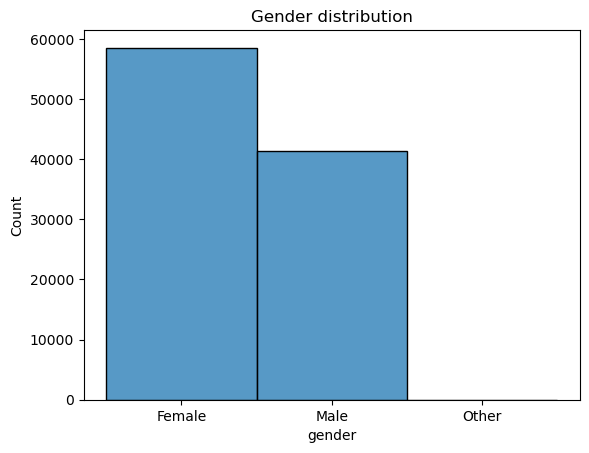

In [8]:
sns.histplot(df["gender"]);
plt.title("Gender distribution")

In [9]:
df["gender"].value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

We can see that the gender 'Other' count value is insignificant compared to the others, so we can drop them since they won't make a huge impact in the data set.

Text(0.5, 1.0, 'Smoking history distribution')

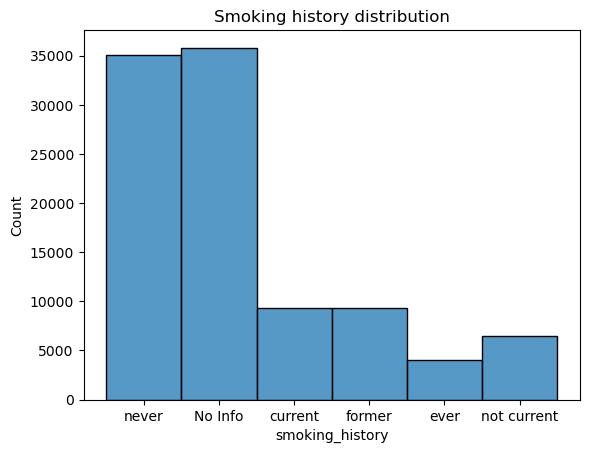

In [10]:
sns.histplot(df["smoking_history"]);
plt.title("Smoking history distribution")

In [11]:
df["smoking_history"].value_counts()

No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64

There's 6 labels upon smoking history label, but some labels are redundant. For example ["ever", "former", "not current"] can be reduced to "has_smoked" label.

/tmp/ipykernel_12382/456105669.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_mat = df.corr()


<Axes: >

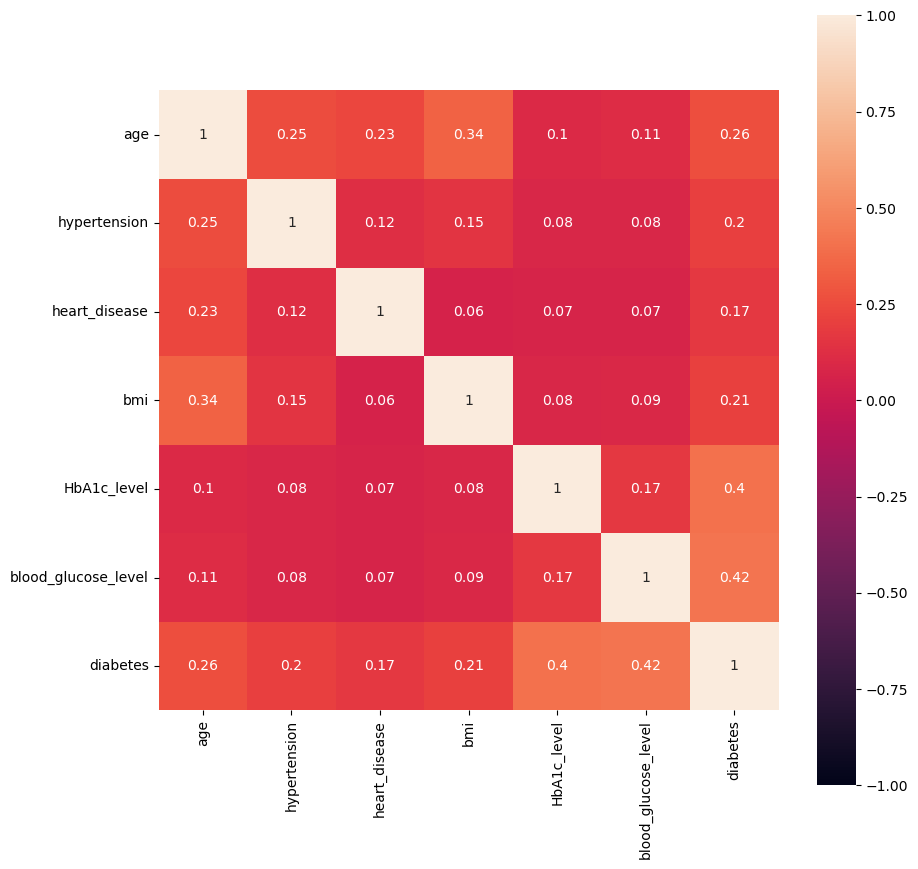

In [11]:
plt.figure(figsize=(10,10))
correlation_mat = df.corr()
sns.heatmap(np.round(correlation_mat, decimals=2),square=True, vmin=-1, vmax=1, annot=True)

In the correlation matrix, we can note that the correlation between the numerical values are, in general, low. For instance, we can think that they might be few "useful" features for the models.

Another important thing to check upon the target column, is to revise if the data set has a balanced between the classes.

<Axes: xlabel='diabetes', ylabel='count'>

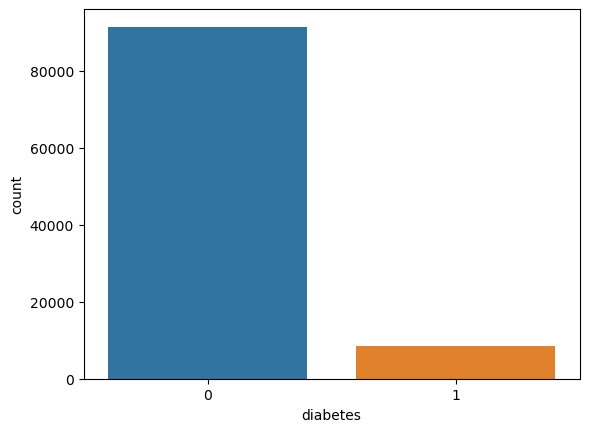

In [12]:
sns.countplot(df, x = "diabetes")

In [13]:
df["diabetes"].value_counts()

0    91500
1     8500
Name: diabetes, dtype: int64

As we can see, the difference between the clases are significant high, so a balance method must be applied.

In [14]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


## Data Preprocess

First step is to balance the taget distribution. In this case, we just undersampled the values that have no diabetes.

,index,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,90088.0,Male,26.0,0,0,ever,27.68,6.0,140,0
1,73279.0,Female,80.0,0,0,No Info,28.29,6.5,100,0
2,99498.0,Female,25.0,0,0,never,27.06,6.6,200,0
3,69122.0,Female,50.0,0,0,former,23.13,5.7,85,0
4,95877.0,Female,68.0,1,0,not current,32.50,4.0,160,0
...,...,...,...,...,...,...,...,...,...,...
99935,NaN,Female,65.0,1,1,never,33.55,8.2,140,1
99938,NaN,Male,55.0,0,1,former,30.42,6.2,300,1
99957,NaN,Female,61.0,0,0,No Info,34.45,6.5,280,1
99962,NaN,Female,58.0,1,0,never,38.31,7.0,200,1


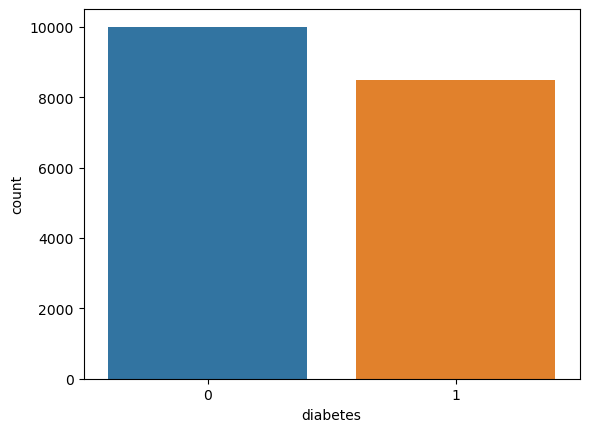

In [15]:
df_non = df[df["diabetes"] == 0].sample(10000, random_state=2).reset_index()
pd.concat([df_non, df[df["diabetes"] != 0]])
dfNew = pd.concat([df_non, df[df["diabetes"] != 0]])
sns.countplot(dfNew, x = "diabetes")
dfNew

In [16]:
df = dfNew.drop("index", axis=1)
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Male,26.0,0,0,ever,27.68,6.0,140,0
1,Female,80.0,0,0,No Info,28.29,6.5,100,0
2,Female,25.0,0,0,never,27.06,6.6,200,0
3,Female,50.0,0,0,former,23.13,5.7,85,0
4,Female,68.0,1,0,not current,32.50,4.0,160,0
...,...,...,...,...,...,...,...,...,...
99935,Female,65.0,1,1,never,33.55,8.2,140,1
99938,Male,55.0,0,1,former,30.42,6.2,300,1
99957,Female,61.0,0,0,No Info,34.45,6.5,280,1
99962,Female,58.0,1,0,never,38.31,7.0,200,1


### One Hot Encoding

In [17]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [18]:
print(df["gender"].unique())
print(df["smoking_history"].unique())

['Male' 'Female' 'Other']
['ever' 'No Info' 'never' 'former' 'not current' 'current']


In [19]:
df = df.drop(df[df['gender']=='Other'].index)
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Male,26.0,0,0,ever,27.68,6.0,140,0
1,Female,80.0,0,0,No Info,28.29,6.5,100,0
2,Female,25.0,0,0,never,27.06,6.6,200,0
3,Female,50.0,0,0,former,23.13,5.7,85,0
4,Female,68.0,1,0,not current,32.50,4.0,160,0
...,...,...,...,...,...,...,...,...,...
99935,Female,65.0,1,1,never,33.55,8.2,140,1
99938,Male,55.0,0,1,former,30.42,6.2,300,1
99957,Female,61.0,0,0,No Info,34.45,6.5,280,1
99962,Female,58.0,1,0,never,38.31,7.0,200,1


As said before, some categories in the "smoking_history" are redundant so in the following section we made a reduction.

In [20]:
# df = dfNew.copy()
df = df.replace(["ever", "former", "not current"], "has_smoked")
df = df.replace(["No Info"], "unknown")
df = df.replace(["current"], "is_smoking")
#print(df["gender"].unique())
print(df["smoking_history"].unique())

['has_smoked' 'unknown' 'never' 'is_smoking']


In [21]:
df = pd.get_dummies(df, drop_first = True)

### Correlation matrix

<Axes: >

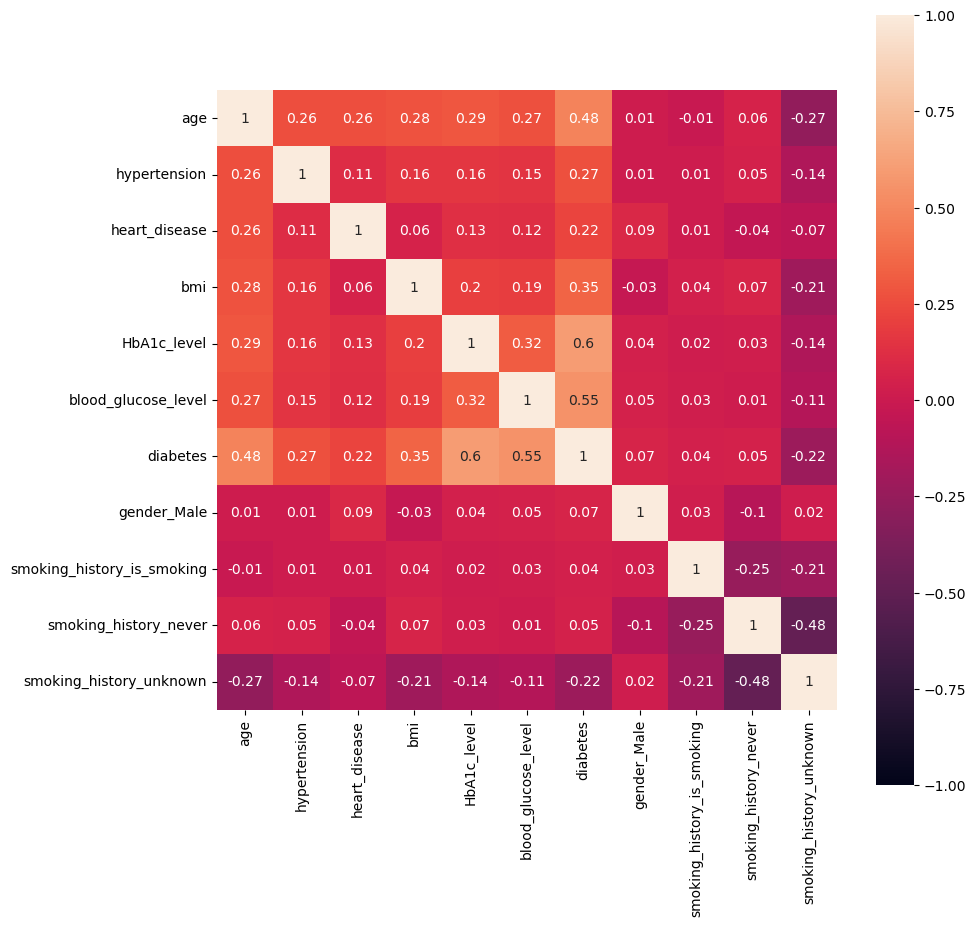

In [22]:
plt.figure(figsize=(10,10))
correlation_mat2 = df.corr()
sns.heatmap(np.round(correlation_mat2, decimals=2),square=True, vmin=-1, vmax=1, annot=True)

In [28]:
corr_target = correlation_mat2.loc['diabetes',:]
corr_target[np.abs(corr_target) > 0.3]

age                    0.484085
bmi                    0.345331
HbA1c_level            0.599588
blood_glucose_level    0.548625
diabetes               1.000000
Name: diabetes, dtype: float64

### Pairplot

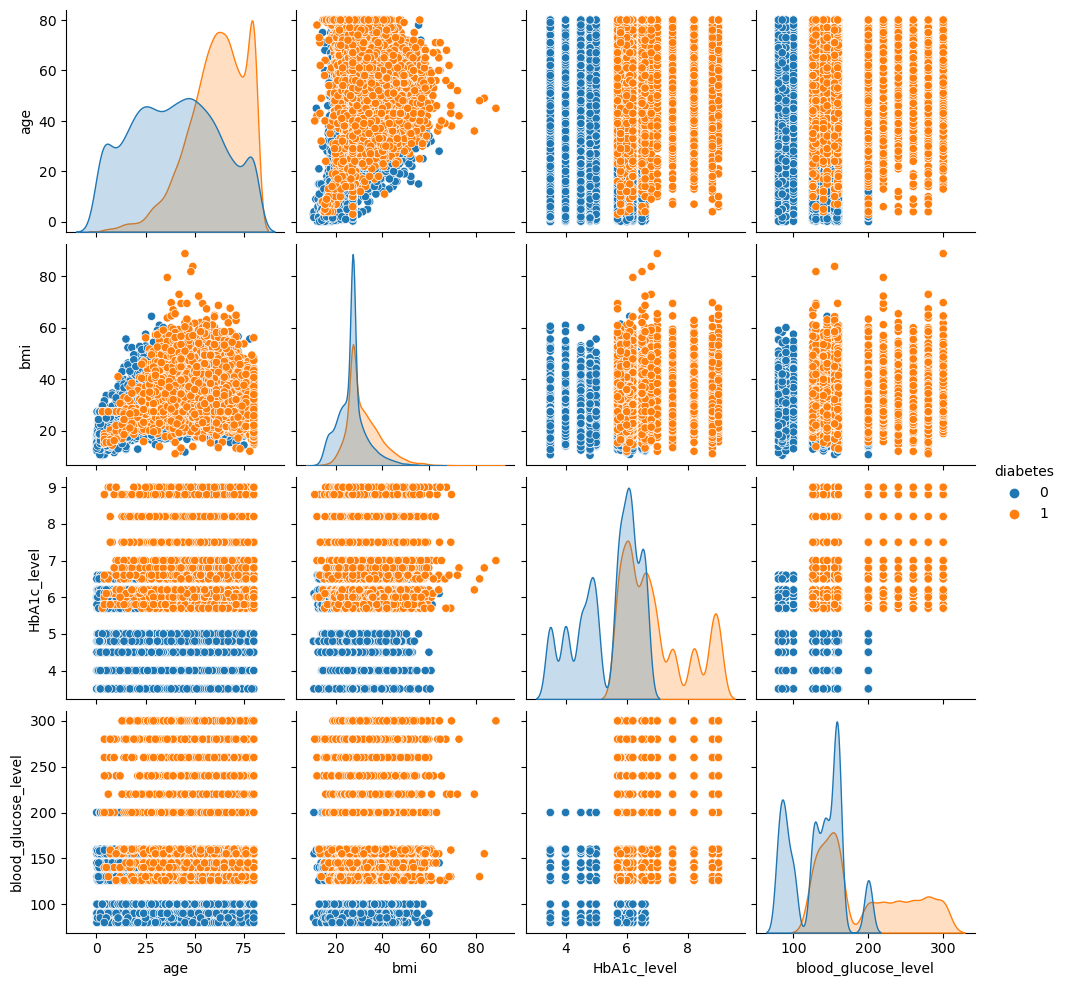

In [29]:
sns.pairplot(df[["age", "bmi", "HbA1c_level", "blood_glucose_level", "diabetes"]], kind="scatter", hue="diabetes")

### Outlayers treatment

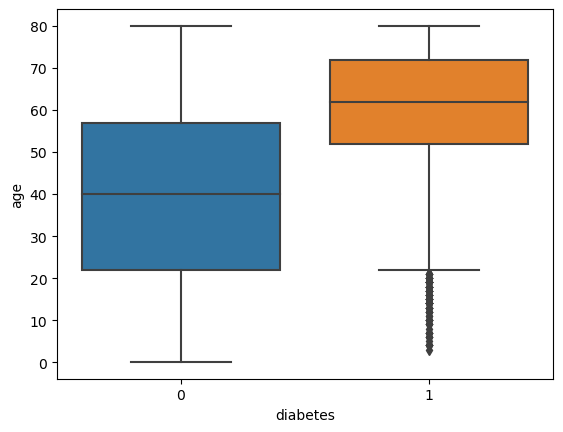

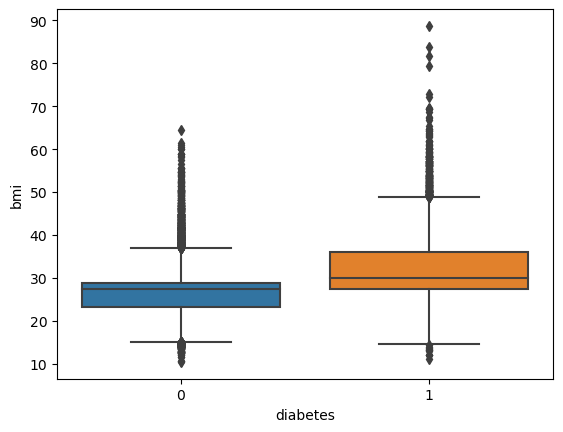

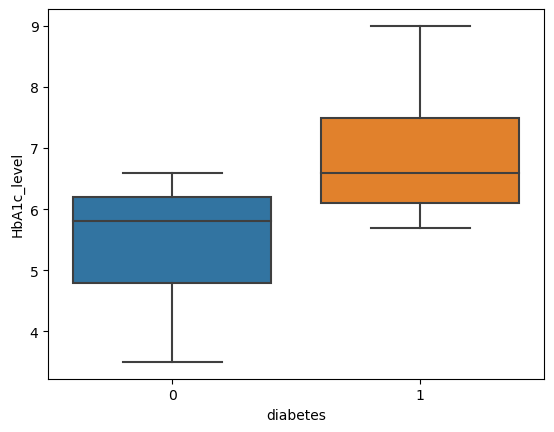

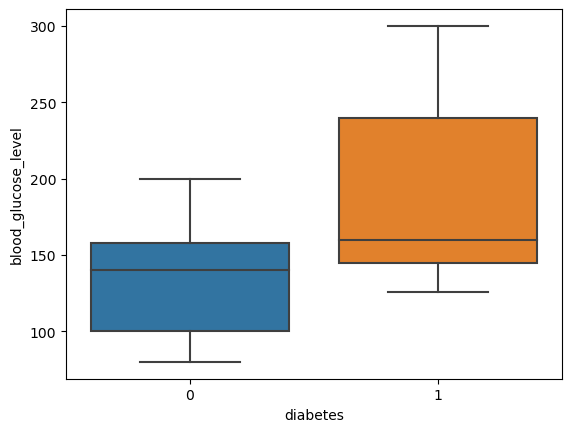

In [42]:
features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
#print(int(np.floor(len(features)/2)))

for feature in features:
    #print(feature)
    plt.figure()
    sns.boxplot(x=df["diabetes"], y=df[feature])

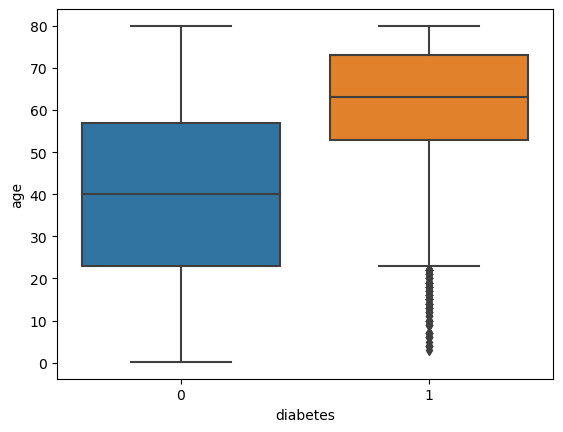

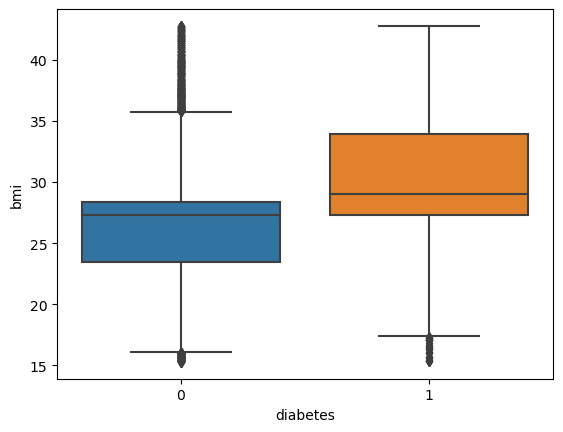

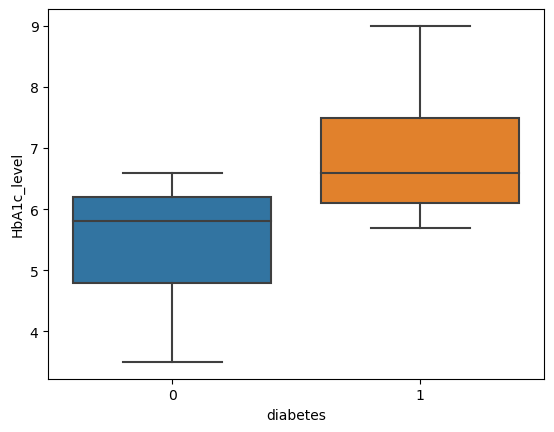

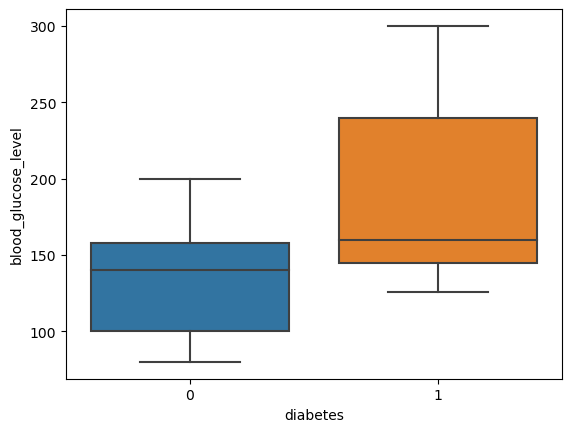

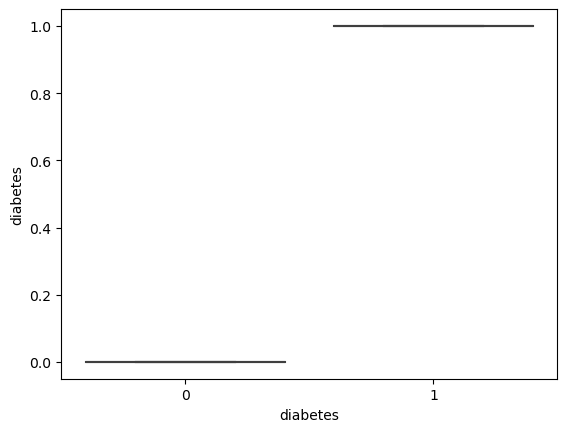

In [31]:
Q1 = df["bmi"].quantile(0.25)
Q3 = df["bmi"].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df["bmi"] >= Q1 - 1.5 * IQR) & (df["bmi"] <= Q3 + 1.5 *IQR)
filt = df.loc[filter]

for feature2 in features:
    plt.figure()
    sns.boxplot(x=filt["diabetes"], y=filt[feature2])

## Training models

In [32]:
# Feature selection
df_model = df[features]
df_model

,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,26.0,27.68,6.0,140,0
1,80.0,28.29,6.5,100,0
2,25.0,27.06,6.6,200,0
3,50.0,23.13,5.7,85,0
4,68.0,32.50,4.0,160,0
...,...,...,...,...,...
99935,65.0,33.55,8.2,140,1
99938,55.0,30.42,6.2,300,1
99957,61.0,34.45,6.5,280,1
99962,58.0,38.31,7.0,200,1


In [33]:
# Split data set
X = df_model.drop("diabetes",axis=1)
Y = df_model["diabetes"]
X_train , X_test , Y_train ,Y_test = train_test_split(X,Y, test_size=0.2, random_state = 2)

### Standarize data

In [34]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_train)

## Logistic regression

In [35]:
log_model = LogisticRegression()
logistic.fit(X_train_std, Y_train)

LogisticRegression()

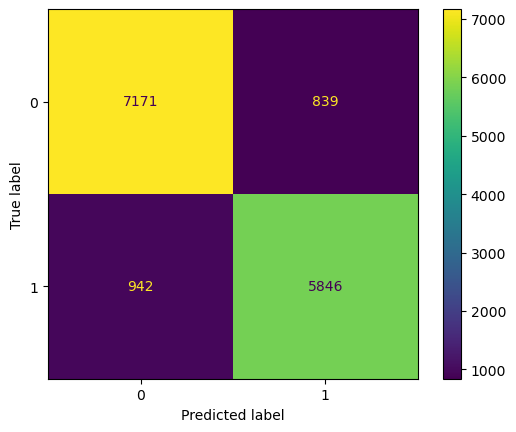

In [36]:
Y_pred = logistic.predict(X_train_std)
confusio = confusion_matrix(Y_train.values, Y_pred)
ConfusionMatrixDisplay(confusio).plot();

In [37]:
print(classification_report(Y_train.values, Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      8010
           1       0.87      0.86      0.87      6788

    accuracy                           0.88     14798
   macro avg       0.88      0.88      0.88     14798
weighted avg       0.88      0.88      0.88     14798



## SVM

In [38]:
svm_default = SVC()
svm_default.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

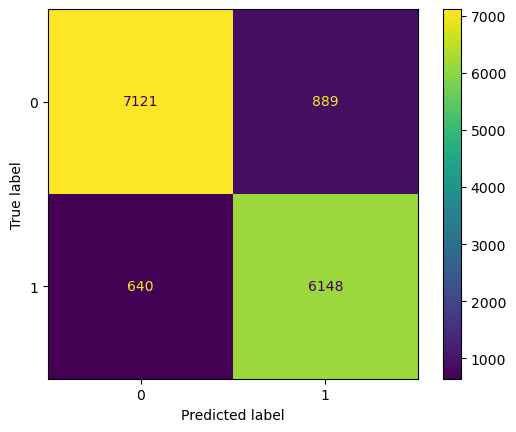

In [39]:
svm_default.fit(X_train_std, Y_train)
Y_pred = svm_default.predict(X_train_std)
confusio = confusion_matrix(Y_train.values, Y_pred)
ConfusionMatrixDisplay(confusio).plot();

In [40]:
print(classification_report(Y_train.values, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      8010
           1       0.87      0.91      0.89      6788

    accuracy                           0.90     14798
   macro avg       0.90      0.90      0.90     14798
weighted avg       0.90      0.90      0.90     14798



### Svm hiparameters tuning

In [67]:
Cs = [1, 10, 100]
gammas = [0.01, 0.001, 0.0001]
parametres = [{'kernel': ['rbf'], 'C': Cs, 'gamma': gammas},
              {'kernel': ['linear'], 'C': Cs}, 
              {'kernel': ['poly'], 'C': Cs, 'degree': np.arange(2, 5)}]

grid = GridSearchCV(SVC(),
                    param_grid = parametres,
                    cv = 5,
                    scoring = 'accuracy',
                    n_jobs=1)

grid_search = grid.fit(X_train_std, Y_train)
grid_search.cv_results_

print("Els millors hiperparàmetres són %s amb una accuracy mitjana de %0.2f"
      % (grid.best_params_, grid.best_score_))


Els millors hiperparàmetres són {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'} amb una accuracy mitjana de 0.90


In [44]:
print(grid_search.cv_results_)

{'mean_fit_time': array([ 8.37699594, 11.25841532,  8.01651444, 13.82661839,  7.32092786,
       13.88017769,  4.7827261 , 32.01652589,  3.23392129, 30.45447564,
        2.12387643,  4.97211938,  2.50109625,  1.44967685,  4.56897578,
        2.08611317,  1.4434978 ,  5.10081215,  1.96736131,  1.79299402,
        5.76218467,  2.05583806,  2.62635732,  7.76196265,  2.25610371]), 'std_fit_time': array([0.20026276, 0.51158855, 0.1963499 , 1.34631567, 0.49817302,
       0.18837379, 0.27408371, 1.16940659, 0.0446676 , 1.8315323 ,
       0.09441805, 0.38955898, 0.10899515, 0.01803205, 0.12696244,
       0.08369903, 0.02212942, 0.3466907 , 0.13823992, 0.09955401,
       0.21064727, 0.14645121, 0.09854449, 0.22690442, 0.12485002]), 'mean_score_time': array([2.09519377, 2.36723871, 2.06051269, 2.25684519, 1.95874095,
       2.16248956, 1.23230553, 2.355059  , 0.83521132, 2.22361717,
       0.41888609, 0.85476599, 0.50889096, 0.30592194, 0.77495666,
       0.40036955, 0.28636084, 0.80608068, 0.35

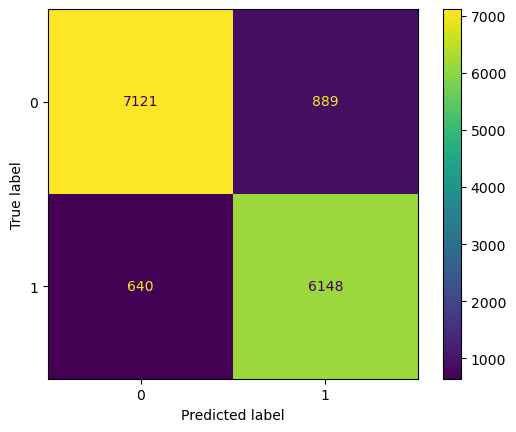

In [68]:
confusio = confusion_matrix(Y_train.values, Y_pred)
ConfusionMatrixDisplay(confusio).plot()

In [66]:
print(classification_report(Y_train.values, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      8010
           1       0.87      0.91      0.89      6788

    accuracy                           0.90     14798
   macro avg       0.90      0.90      0.90     14798
weighted avg       0.90      0.90      0.90     14798



### Random forest

In [72]:
rf = RandomForestClassifier()

# grid search cv

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [10, 100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [2, 4, 8, 16],
    'max_leaf_nodes': [2, 4, 8, 16],
}

grid = GridSearchCV(rf,param_grid=param_grid,cv=3,scoring='accuracy')
model_grid = grid.fit(X_train_std,Y_train)

# grid search results
print('Best grid search hyperparameters are: '+str(model_grid.best_params_))
print('Best grid search score is: '+str(model_grid.best_score_))


Best grid search hyperparameters are: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 150}
Best grid search score is: 0.8985674598144469


In [63]:
confusio = confusion_matrix(Y_train.values, Y_pred)
ConfusionMatrixDisplay(confusio).plot()
print(classification_report(Y_train.values, Y_pred))

[0.1   0.325 0.55  0.775 1.   ]
